# Qiskit Dynamic Circuits

In [1]:
# Dynamic Circuit Example: Long-range CNOT gate teleportation

# This is based on the following Nature paper written by IBM Quantum: 
# https://www.ibm.com/quantum/blog/nature-qldpc-error-correction

# Step 1: Mapping

In [2]:
# Map the proble to circuits and operators

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

"""
Assumptions:
(1) 1D chain of nearest neighbors
(2) 0th qubit is the control, and the last qubit (num_qubit - 1) is the target
(3) The control qubit starts in the + state
"""

#we want to perform a CNOT gate over a very large distance: qubit 0 = control; qubit num_qubit - 1 = target; in between are ancilla qubits

def get_dynamic_CNOT_circuit(num_qubit): 
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name = "cr1") #parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name = "cr2") # parity-controlled Z gate
    cr3 = ClassicalRegister(2, name = "cr3") #for final measurements on the control and taret qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    #initialize the control qubit:
    qc.h(0)
    qc.barrier()

    #entangle control qubit and 1st ancilla qubit:
    qc.cx(0, 1) #qubit 1 is the ancilla qubit (performs parity checks on qubit 0 to find noise)

    #create Bell pairs on the ancilla qubits
    #i starts from 0
    for i in range(num_ancilla_pair): #makes a Bell state: h(0) and cx(0, 1)
        qc.h(2+2*i) #h(0), h(4), ...
        qc.cx(2+2*i, 2+2*i+1) #CNOT(0, 1), CNOT(2, 3), ...

    #prepare Bell pairs between every even-odd pair of ancilla and data qubits, starting from qubit 1:
    for i in range(num_ancilla_pair + 1):
        qc.cx(1+2*i, 1+2*i+1) #cx(1, 2), cx(3, 4), ...
    for i in range(1, num_ancilla_pair + 2): #starts from qubit 1, not 0
        qc.h(2*i-1) #h(1), h(2), ...

    #measurement on odd-indexed ancilla qubits, starting from qubit 1:
    #keep track of the parity for eventual conditional Z gate
    for i in range(1, num_ancilla_pair + 2):
        qc.measure(2*i - 1, cr2[i - 1]) #stores measured state of qreg[1] --> cr1[0], qreg[3] --> cr1[2], ...
        if i == 1:
            parity_control = expr.lift(cr2[i - 1]) 
        else:
            parity_control = expr.bit_xor(cr2[i - 1], parity_control) #computes the parity of measured state

    #measurement on even-indexed ancilla qubits starting with the 2nd:
    #keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    with qc.if_test(parity_control):
        qc.z(0)

    with qc.if_test(parity_target):
        qc.x(-1)

    # Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])
        
    return qc

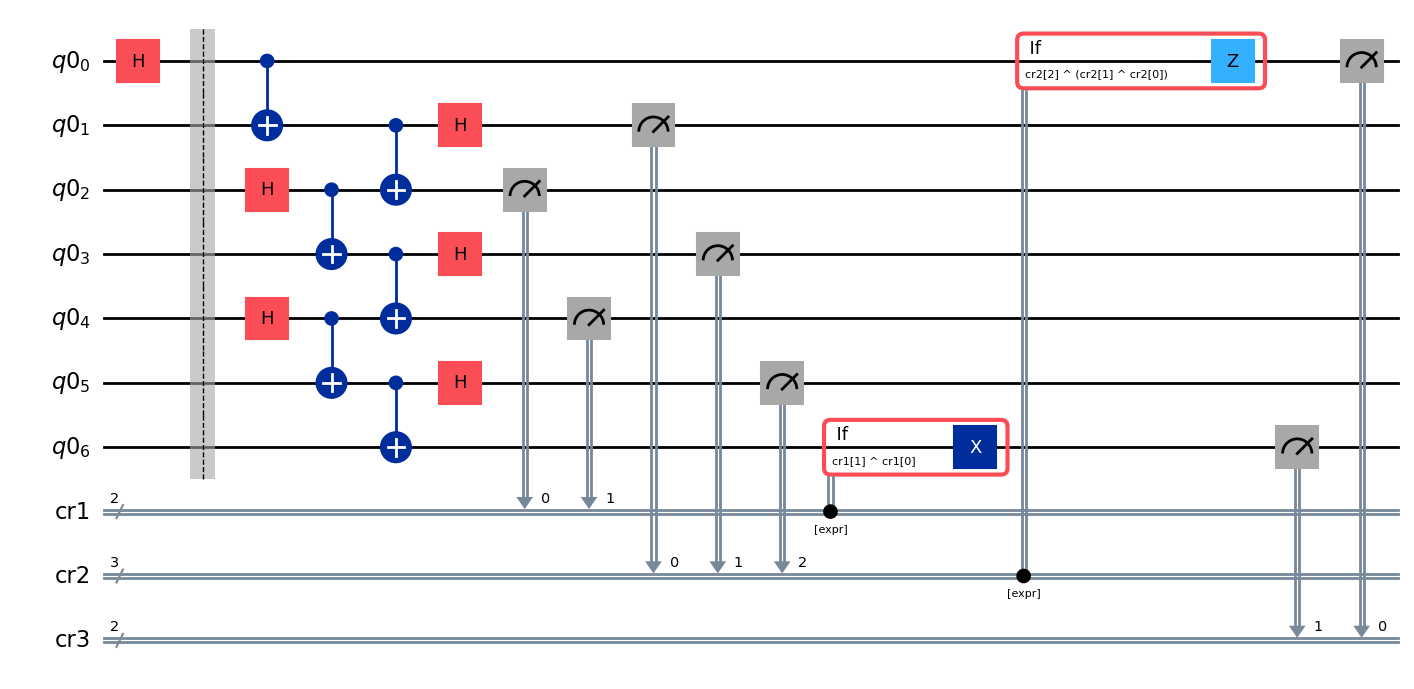

In [3]:
qc = get_dynamic_CNOT_circuit(num_qubit = 7)
qc.draw(output = 'mpl')

In [4]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit + 1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

# Step 2: Optimization

In [21]:
# Optimize the problem for quantum execution

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(optimization_level = 1, backend = backend)

qc_transpiled_list = pm.run(qc_list)

/var/folders/cp/l_nj7m8d1vbcnqdgjq_mg5_80000gn/T/ipykernel_71764/681703935.py:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


# Step 3: Execute

In [ ]:
# Execute the circuit

from qiskit_ibm_runtime import SamplerV2 as Sampler, Session

with Session(backend=backend) as session:
    sampler = Sampler() #instead of sampler = Sampler(backend = backend)

    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

# Step 4: Post-Process

In [ ]:
# Post-processing and plotting

import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = ''

service = QiskitRuntimeService
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []

for i in range(0, len(qc_list)):
    data = result[i + 1].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00'] + counts ['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1 - prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label = '00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label = 'other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()